In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import jsonlines
import re
import string
import shutil
import os
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType

First of all we wnat to filter channels that do not have much subscribers, to make the datasets smaller. Let us study the ditributuion of number of subscribers per channel.

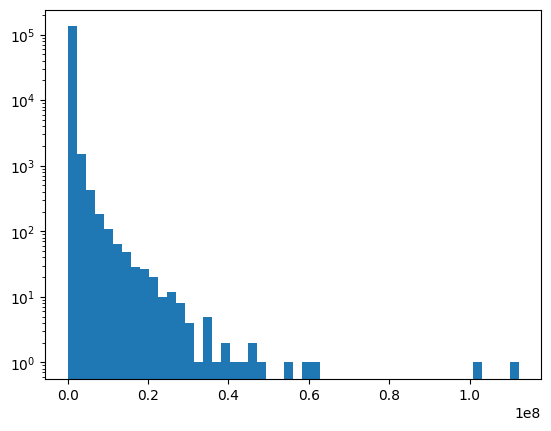

In [2]:
#histogram of number of subscribers per channels

all_channels = pd.read_csv("data/df_channels_en.tsv", sep = "\t")
plt.hist(all_channels['subscribers_cc'], log=True, bins= 50)
plt.show()


In [3]:
threshold = 100000
percentage = (all_channels['subscribers_cc'] < threshold).mean() * 100 
print(f"Percentage of channels with less than {threshold} subsrcribers: {percentage}%")

Percentage of channels with less than 100000 subsrcribers: 69.18663442514838%


We filter out channels that have lest than this threshold subscribers and create a new datasets.

In [4]:
filtered_channels = all_channels.query(f'subscribers_cc >= {threshold}')
filtered_channels.to_csv('data/df_filtered_channels.tsv', index= False)

Now we have to select videos which only belongs to these channels.

TEST SQL efficiency ?

In [ ]:
sc = SparkContext()
spark = SparkSession.builder.appName("yourAppName").getOrCreate()

23/11/12 13:11:19 WARN Utils: Your hostname, MacBook-Pro-de-Paul-2.local resolves to a loopback address: 127.0.0.1; using 192.168.1.33 instead (on interface en0)
23/11/12 13:11:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/12 13:11:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
#test spark sql
video_schema = StructType([
    StructField("channel_id", StringType(), True),
])

video_file_path = 'data/sampled_dataset.jsonl'
video_raw_data = sc.textFile(video_file_path)
video_json_data = video_raw_data.map(lambda x: json.loads(x))
video_df = spark.createDataFrame(video_json_data, schema=video_schema)

channels_file_path = 'data/df_filtered_channels.tsv'
channels_df = spark.read.option("delimiter", "\t").csv(channels_file_path, header=True, inferSchema=True)

video_df.createOrReplaceTempView("video")
channels_df.createOrReplaceTempView("channels")

filtered_videos = spark.sql("SELECT * FROM video WHERE channel_id IN (SELECT channel FROM channels)")

filtered_videos_path = "data/df_filtered_videos.jsonl"
json_data = filtered_videos.rdd.collect()

with jsonlines.open(filtered_videos_path, "w") as jsonl_file:
    jsonl_file.write_all(json_data)

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `channel` cannot be resolved. Did you mean one of the following? [`category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights`].; line 1 pos 48;
'Project [*]
+- 'Filter channel_id#0 IN (list#21 [])
   :  +- 'Project ['channel]
   :     +- SubqueryAlias channels
   :        +- View (`channels`, [category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights#19])
   :           +- Relation [category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights#19] csv
   +- SubqueryAlias video
      +- View (`video`, [channel_id#0])
         +- LogicalRDD [channel_id#0], false


In [ ]:
sc = SparkContext()

video_file_path = 'data/sampled_dataset.jsonl' #"/Volumes/Maxtor/DATA/yt_metadata_en.jsonl"
video_raw_data = sc.textFile(video_file_path)
video_dataset = video_raw_data.map(lambda x: json.loads(x))

channels_file_path = 'data/df_filtered_channels.tsv'
channels_dataset = pd.read_csv(channels_file_path)

filtered_videos = video_dataset.filter(
                               lambda x : x['channel_id'] in channels_dataset['channel'].tolist())


filtered_videos_path = "data/df_filtered_videos.jsonl"

json_data = filtered_videos.collect()

with jsonlines.open(filtered_videos_path, "w") as jsonl_file:
    jsonl_file.write_all(json_data)


23/11/12 11:30:54 WARN Utils: Your hostname, MacBook-Pro-de-Paul-2.local resolves to a loopback address: 127.0.0.1; using 192.168.1.33 instead (on interface en0)
23/11/12 11:30:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/12 11:30:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
